In [16]:
# packages

# JAX
import jax.numpy as np
from jax import grad, hessian, vmap
from jax.config import config; 
config.update("jax_enable_x64", True)

# numpy
import numpy as onp
from numpy import random 

# plot figures
import matplotlib.pyplot as plt

Solve the PDE $$-\Delta u + \alpha u^m = f$$ 
subject to boundary conditions $$u = g$$
on the unit box in 2D. 

There are two parameters: $\alpha$ and $m$ controlling the nonlinearity of this equation

In [49]:
# dimension of the PDEs
dim = 2

# set parameters
alpha = 1
m = 11

# fix random seeds, for generating reference solution & sampled points
random.seed(20)

# ground truth solution
def u(x1, x2):
    return np.sin(np.pi*x1)*np.sin(np.pi*x2) + np.sin(2*np.pi*x1)*np.sin(4*np.pi*x2)
#     return np.sin(np.pi*x1) * np.sin(np.pi*x2) + 2*np.sin(4*np.pi*x1) * np.sin(4*np.pi*x2)

# right hand side
def f(x1, x2):
    return -grad(grad(u,0),0)(x1, x2)-grad(grad(u,1),1)(x1, x2)+alpha*(u(x1, x2)**m)

# boundary value
def g(x1, x2):
    return u(x1, x2)


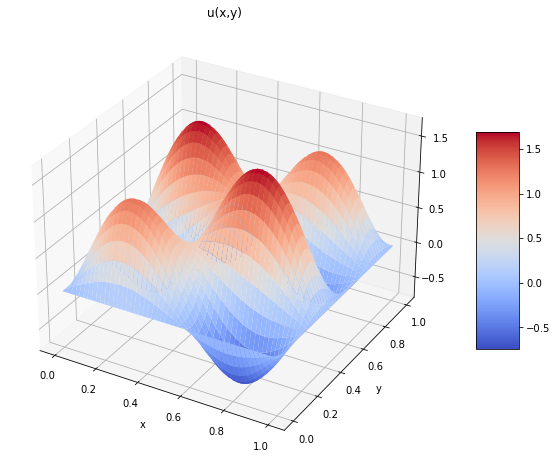

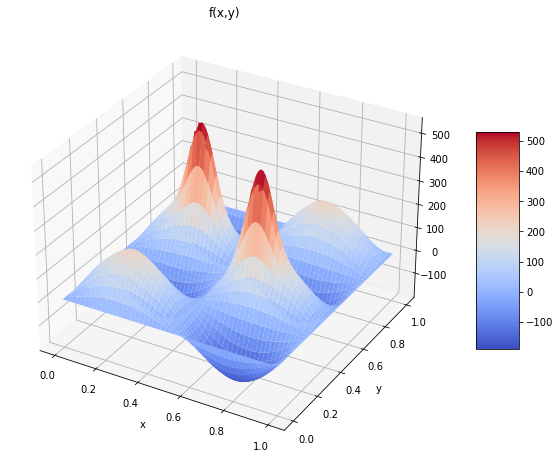

In [50]:
# plot the figure for u and f

def plot_u(num_pts):
    xx = np.linspace(0, 1, num_pts)
    yy = np.linspace(0, 1, num_pts)
    XX, YY = np.meshgrid(xx, yy)

    # vectorized (x,y) coordinates
    XXv = np.array(XX.flatten())
    YYv = np.array(YY.flatten())

    ZZ_u = vmap(u)(XXv, YYv)
    ZZ_u = ZZ_u.reshape(num_pts,num_pts)
    
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')
    u_surf=ax.plot_surface(XX, YY, ZZ_u, cmap=plt.cm.coolwarm)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('u(x,y)')
    
    fig.colorbar(u_surf, shrink= 0.5, aspect = 5)
    plt.show()

def plot_f(num_pts):
    xx = np.linspace(0, 1, num_pts)
    yy = np.linspace(0, 1, num_pts)
    XX, YY = np.meshgrid(xx, yy)

    # vectorized (x,y) coordinates
    XXv = np.array(XX.flatten())
    YYv = np.array(YY.flatten())

    ZZ_f = vmap(f)(XXv, YYv)
    ZZ_f = ZZ_f.reshape(num_pts,num_pts)
    
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')
    f_surf=ax.plot_surface(XX, YY, ZZ_f, cmap=plt.cm.coolwarm)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('f(x,y)')
    
    fig.colorbar(f_surf, shrink= 0.5, aspect = 5)
    plt.show()
    
plot_u(100)
plot_f(100)

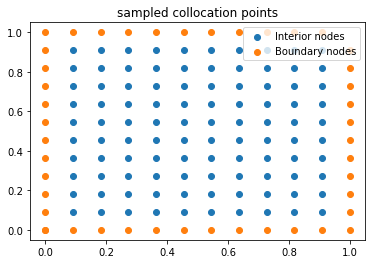

In [51]:
# sampled collocation points

def sample_points_grid(N_pts):
    # N_pts is num of interior nodes each dimension
    N_domain = N_pts**2
    N_boubdary = 4*(N_pts+1)
    
    xx= np.linspace(0, 1, N_pts+2)
    yy = np.linspace(0, 1, N_pts+2)
    XX, YY = np.meshgrid(xx, yy)

    XX_int = XX[1:N_pts+1, 1:N_pts+1]
    YY_int = YY[1:N_pts+1, 1:N_pts+1]

    # vectorized (x,y) coordinates
    XXv_int = np.array(XX_int.flatten())
    YYv_int = np.array(YY_int.flatten())

    XXv_int = np.expand_dims(XXv_int, axis=1) 
    YYv_int = np.expand_dims(YYv_int, axis=1) 
    
    XXv_bd = np.concatenate((XX[0,0:N_pts+1], XX[N_pts+1,0:N_pts+1], XX[0:N_pts+1,0], XX[0:N_pts+1,N_pts+1]), axis = 0)
    YYv_bd = np.concatenate((YY[0,0:N_pts+1], YY[N_pts+1,0:N_pts+1], YY[0:N_pts+1,0], YY[0:N_pts+1,N_pts+1]), axis = 0)

    XXv_bd = np.expand_dims(XXv_bd, axis=1) 
    YYv_bd = np.expand_dims(YYv_bd, axis=1) 
    
    X_domain = np.concatenate((XXv_int, YYv_int), axis=1)
    X_boundary = np.concatenate((XXv_bd, YYv_bd), axis=1)
    return X_domain, X_boundary

N_pts = 10
N_domain_tot = N_pts**2
N_boundary_tot = 4*(N_pts+1)
X_domain_tot, X_boundary_tot = sample_points_grid(N_pts)

fig, ax = plt.subplots()
ax.scatter(X_domain_tot[:, 0], X_domain_tot[:, 1], label='Interior nodes')
ax.scatter(X_boundary_tot[:, 0], X_boundary_tot[:, 1], label='Boundary nodes')
ax.legend(loc="upper right")
plt.title('sampled collocation points')
plt.show()

In [52]:
# Define a real valued kernel kappa(x, y; sigma) \to R
# def kappa(x1, x2, y1, y2, sigma):
#     # x,y are 2D input row vectors
#     # sigma is the variance parameter
#     return np.exp(-(1/(2*sigma**2))*( (x1- y1)**2 + (x2 - y2)**2 ))

eps = 1e-8
def kappa(x1, x2, y1, y2, sigma):
    dist = np.sqrt(np.sum((x1- y1)**2 + (x2 - y2)**2+ eps))
    val = (15*sigma**3+15*np.sqrt(7)*(sigma**2)*dist+42*sigma*(dist**2)+7*np.sqrt(7)*dist**3)/(15*sigma**3)*np.exp(-np.sqrt(7)*dist/sigma)
    return val

# define derivatives of the kernel 
def Delta_x_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(kappa, 0), 0)(x1, x2, y1, y2, sigma)
    val += grad(grad(kappa, 1), 1)(x1, x2, y1, y2, sigma)
    return val

def Delta_y_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(kappa, 2), 2)(x1, x2, y1, y2, sigma)
    val += grad(grad(kappa, 3), 3)(x1, x2, y1, y2, sigma)
    return val

def Delta_x_y_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(Delta_y_kappa, 0), 0)(x1, x2, y1, y2, sigma)
    val += grad(grad(Delta_y_kappa, 1), 1)(x1, x2, y1, y2, sigma)
    return val


In [53]:
# vectorized construction of Theta
def assembly_Theta(X_domain, X_boundary, nugget, set_sigma):
    N_domain = X_domain.shape[0]
    N_boundary = X_boundary.shape[0]
    Theta = onp.zeros((2*N_domain + N_boundary, 2*N_domain + N_boundary))

    # auxiliary variables to make things readable
    Xd0=X_domain[:N_domain, 0]
    Xd1=X_domain[:N_domain, 1]

    Xdb0=np.concatenate([Xd0, X_boundary[:N_boundary, 0]])
    Xdb1=np.concatenate([Xd1, X_boundary[:N_boundary, 1]])

    # interior -- interior 
    XXdd0=np.transpose(np.tile(Xd0,(N_domain,1)))
    XXdd1=np.transpose(np.tile(Xd1,(N_domain,1)))

    # interior+boudary -- interior+bpundary
    XXdbdb0=np.transpose(np.tile(Xdb0,(N_domain+N_boundary,1)))
    XXdbdb1=np.transpose(np.tile(Xdb1,(N_domain+N_boundary,1)))

    # interior v.s. interior+boundary
    XXddb0=np.transpose(np.tile(Xd0,(N_domain+N_boundary,1)))
    XXddb1=np.transpose(np.tile(Xd1,(N_domain+N_boundary,1)))
    XXddb0_2=np.tile(Xdb0,(N_domain,1))
    XXddb1_2=np.tile(Xdb1,(N_domain,1))

    # Construct kernel matrix
    # interior v.s. interior (Laplace)
    val = vmap(lambda x1, x2, y1, y2: Delta_x_y_kappa(x1, x2, y1, y2, set_sigma))(XXdd0.flatten(),XXdd1.flatten(),onp.transpose(XXdd0).flatten(),onp.transpose(XXdd1).flatten())
    Theta[0:N_domain, 0:N_domain] =  onp.reshape(val, (N_domain, N_domain))
    
    # interior+boundary v.s. interior+boundary
    val = vmap(lambda x1, x2, y1, y2: kappa(x1, x2, y1, y2, set_sigma))(XXdbdb0.flatten(),XXdbdb1.flatten(),onp.transpose(XXdbdb0).flatten(),onp.transpose(XXdbdb1).flatten())
    Theta[N_domain:, N_domain:] =  onp.reshape(val, (N_domain+N_boundary, N_domain+N_boundary))

    # interior v.s. interior+boundary
    val = vmap(lambda x1, x2, y1, y2: Delta_x_kappa(x1, x2, y1, y2, set_sigma))(XXddb0.flatten(),XXddb1.flatten(),XXddb0_2.flatten(),XXddb1_2.flatten())
    Theta[:N_domain, N_domain:] = onp.reshape(val, (N_domain, N_domain+N_boundary))
    Theta[N_domain:, :N_domain] = onp.transpose(onp.reshape(val, (N_domain, N_domain+N_boundary)))
    
    # calculate trace
    trace1 = np.trace(Theta[:N_domain, :N_domain])
    trace2 = np.trace(Theta[N_domain:, N_domain:])
    ratio = trace1/trace2
    
    temp=np.concatenate((ratio*np.ones((1,N_domain)),np.ones((1,N_domain+N_boundary))), axis=1)
    Theta = Theta + set_nugget*np.diag(temp[0])
    L = np.linalg.cholesky(Theta)
    
    return L, ratio

# test
set_sigma = 0.3
set_nugget = 1e-10
L, ratio = assembly_Theta(X_domain_tot, X_boundary_tot, set_nugget, set_sigma)
print('trace ratio =', ratio)
print('observation: the trace ratio is large, and our adaptive nugget term is effective')

trace ratio = 2240.515087603304
observation: the trace ratio is large, and our adaptive nugget term is effective


In the above, we added nugget terms to regularize the Gram matrix
\begin{equation*}
\Theta_{\lambda} = \Theta +
\text{nugget}\times\begin{bmatrix}
\lambda I & 0 \\
0 & I 
\end{bmatrix}
\end{equation*}
where $\lambda$ is selected to be the trace ratio of the orginal Gram matrix

Then, we solve the following optimization problem:
\begin{equation*}
\begin{aligned}
\min&\quad   [v,w,u_b]\Theta_{\lambda}^{-1} [v,w,u_b]^T\\
  \text{s.t.}&\quad -v+\alpha w^m=f, \text{ and } u_b = \text{boundary data}
\end{aligned}
\end{equation*}

Here, $v,w$ represent the interior nodal values of $\Delta u(x_i), u(x_i)$, respectively.

iter = 0 J = 146150729.7487141
iter =  1 Gauss-Newton step size = 1  J =  17505062.776741464
iter =  2 Gauss-Newton step size = 1  J =  2274435.4346170295
iter =  3 Gauss-Newton step size = 1  J =  285750.7291445562
iter =  4 Gauss-Newton step size = 1  J =  37666.19576514652
iter =  5 Gauss-Newton step size = 1  J =  5710.006974844875
iter =  6 Gauss-Newton step size = 1  J =  1582.5114957502371
iter =  7 Gauss-Newton step size = 1  J =  316.491263485087
iter =  8 Gauss-Newton step size = 1  J =  80.22619196139655
iter =  9 Gauss-Newton step size = 1  J =  41.68297925235059
iter =  10 Gauss-Newton step size = 1  J =  41.65905905793472


Text(0.5, 1.0, 'Loss function history')

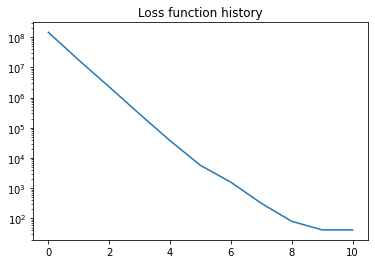

In [54]:
# loss function
def J(z,rhs_f,bdy_g,L):
    zz = np.append(alpha*(z**m) - rhs_f, z) 
    ww = np.append(zz, bdy_g)
    ss = np.linalg.solve(L, ww)
    return np.dot(ss, ss)

grad_J=grad(J)

# linearized loss function: used for GN method
def GN_J(z,rhs_f,bdy_g,L,z_old):
    zz = np.append(alpha*m*(z_old**(m-1))*(z-z_old), z) 
    ww = np.append(zz, bdy_g)
    ss = np.linalg.solve(L, ww)
    return np.dot(ss, ss)

Hessian_GN=hessian(GN_J)
Hessian_J=hessian(J)

def pde_solver(X_domain, X_boundary, nugget, max_iter, step_size, initial_sol, set_sigma):
    rhs_f = vmap(f)(X_domain[:,0], X_domain[:,1])
    bdy_g = vmap(u)(X_boundary[:,0], X_boundary[:,1])
    L, ratio = assembly_Theta(X_domain, X_boundary, nugget, set_sigma)

    sol = initial_sol
    J_hist = [] # history of loss function values
    J_now = J(sol,rhs_f,bdy_g,L)
    J_hist.append(J_now)
    
    print('iter = 0', 'J =', J_now) # print out history
    
    for iter_step in range(1, max_iter+1):
        temp = np.linalg.solve(Hessian_GN(sol,rhs_f,bdy_g,L,sol), grad_J(sol,rhs_f,bdy_g,L))
        sol = sol - step_size*temp  
        
        J_now = J(sol,rhs_f,bdy_g,L)
        J_hist.append(J_now)
        # print out history
        print('iter = ', iter_step, 'Gauss-Newton step size =', step_size, ' J = ', J_now)               
    return sol, J_hist, rhs_f, bdy_g, L

initial_sol = random.normal(0.0, 1.0, (N_domain_tot)) # random initial guess
max_iter = 10
step_size = 1
set_sigma = 0.2
set_nugget = 1e-10
sol, J_hist, rhs_f, bdy_g, L = pde_solver(X_domain_tot, X_boundary_tot, set_nugget, max_iter, step_size, initial_sol, set_sigma)

plt.plot(np.arange(max_iter+1),J_hist)
plt.yscale("log")
plt.title('Loss function history')

In [55]:
# err at collocation points

sol_truth = vmap(u)(X_domain_tot[:,0], X_domain_tot[:,1])
err_pts = abs(sol_truth-sol)

max_err_pts = onp.max(err_pts)

L2_err_pts = onp.sqrt(np.sum(err_pts**2) / (N_domain_tot))

print('At collocation points, L2 err= ', L2_err_pts, ' max err=', max_err_pts)

At collocation points, L2 err=  0.03843453186106017  max err= 0.07662840824344352


In [56]:
# Laplace approximation
mean_Laplace = sol
cov_Laplace = np.linalg.inv(Hessian_J(sol,rhs_f, bdy_g, L))
cov_Kalman = np.linalg.inv(Hessian_GN(sol,rhs_f, bdy_g, L,sol))

In [61]:
XX = np.reshape(X_domain_tot[:,0], (N_pts, N_pts))
YY = np.reshape(X_domain_tot[:,1], (N_pts, N_pts))
grid_sol = np.reshape(sol, (N_pts, N_pts))
grid_cov_Laplace = np.reshape(np.diag(cov_Laplace),(N_pts, N_pts))
grid_cov_Kalman = np.reshape(np.diag(cov_Kalman),(N_pts, N_pts))
grid_truth = np.reshape(sol_truth, (N_pts, N_pts))

grid_Delta_truth = vmap(f)(X_domain_tot[:,0], X_domain_tot[:,1])
grid_Delta_truth = np.reshape(grid_Delta_truth, (N_pts, N_pts))

<ipython-input-63-4520566e99dc>:3: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contourf(XX, YY, grid_sol, label = "MAP")
<ipython-input-63-4520566e99dc>:7: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contourf(XX, YY, grid_cov_Kalman, label = "GaussNewtonLaplace_std")
<ipython-input-63-4520566e99dc>:11: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contourf(XX, YY, grid_cov_Laplace, label = "Laplace_std")


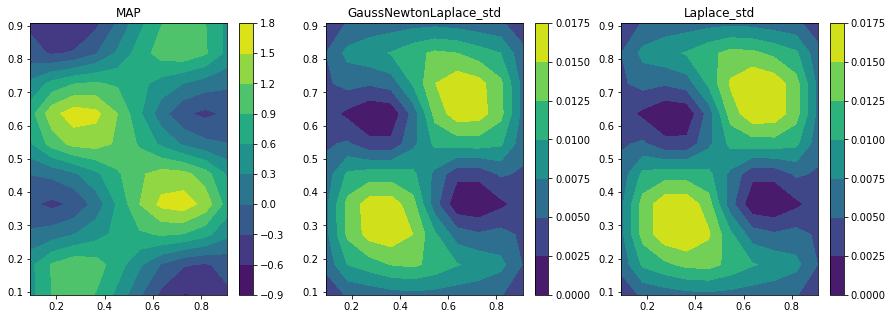

In [63]:
fig_approx = plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.contourf(XX, YY, grid_sol, label = "MAP")
plt.title("MAP")
plt.colorbar()
plt.subplot(132)
plt.contourf(XX, YY, grid_cov_Kalman, label = "GaussNewtonLaplace_std")
plt.title("GaussNewtonLaplace_std")
plt.colorbar()
plt.subplot(133)
plt.contourf(XX, YY, grid_cov_Laplace, label = "Laplace_std")
plt.title("Laplace_std")
plt.colorbar()
# legend()